# PHASE 1 - CLUSTERING

In [ ]:
# ================================================================
# PHASE 1 - CLUSTERING
# ================================================================
# 
# Goal: Apply clustering to indentify customer segmentations
#
# Sections:
#   1.0 - Setup & Data Loading
#   1.1 - Model Comparison
#   1.2 - Model Selection
#   1.3 - Final Model Training
#   1.4 - Cluster Characterization
# ================================================================

## 1.0 - Setup & Data Loading

In [ ]:
# ================================================================
# 1.0 - Setup & Data Loading
# ================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score

SEED = 000

In [ ]:
# -----------------------------------------------
# Load data from Phase 0
# -----------------------------------------------
print("\nLoading processed features from Phase 0...")

user_features_scaled = pd.read_parquet('../data/processed/user_features_scaled.parquet')

print(f"Loaded user_features_scaled: {user_features_scaled.shape}")
print(f"Features: {user_features_scaled.shape[1] - 1} (excluding user_id)\n")

# Verify
display(user_features_scaled.head(3))


Loading processed features from Phase 0...
Loaded user_features_scaled: (175072, 164)
Features: 163 (excluding user_id)



,user_id,recency,frequency,monetary,avg_basket_size,reorder_ratio,preferred_dow,preferred_hour,avg_order_interval,dept_frozen,...,aisle_trail_mix_snack_mix,aisle_feminine_care,aisle_body_lotions_soap,aisle_tortillas_flat_bread,aisle_frozen_appetizers_sides,aisle_hot_cereal_pancake_mixes,aisle_dry_pasta,aisle_beauty,aisle_muscles_joints_pain_relief,aisle_specialty_wines_champagnes
0,1,-1.457436,-0.251190,-0.537150,-0.681460,1.199945,-0.525582,-1.310955,0.582043,-0.872076,...,-0.115065,-0.120518,-0.17741,-0.38111,-0.329238,-0.334596,-0.456518,-0.082656,-0.115729,-0.065917
1,2,1.510267,0.165284,0.602558,0.800590,0.080030,-0.525582,-0.554761,0.167608,0.230958,...,-0.115065,-0.120518,-0.17741,-0.38111,-0.329238,-0.334596,-0.456518,-0.082656,-0.115729,-0.065917
2,3,0.224262,-0.133218,-0.153176,-0.165063,0.590630,-1.010615,0.957625,-0.348404,0.089497,...,-0.115065,-0.120518,-0.17741,-0.38111,-0.329238,-0.334596,-0.456518,-0.082656,-0.115729,-0.065917


In [3]:
user_id = "user_id"
feature_cols = [c for c in user_features_scaled.columns if c != user_id]

X_scaled = user_features_scaled[feature_cols]
print(X_scaled.shape)

(175072, 163)


## 1.1 - Model Comparison

In [ ]:
# ================================================================
# 1.1 - Model Comparison
# ================================================================

# -----------------------------------------------
# Principal Component Analysis
# -----------------------------------------------

from sklearn.decomposition import PCA

# Explain 90% of variance
pca = PCA(n_components=0.80, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: 163")
print(f"PCA components: {X_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

Original features: 163
PCA components: 99
Variance explained: 80.43%


K-means with PCA: 100%|███████████████████████████████████████████████████████| 5/5 [01:30<00:00, 18.07s/it]


,k,inertia,silhouette,davies_bouldin,sil_norm,db_norm,combined_score
2,5,3.665090e+06,0.022071,4.152322,1.000000,0.801629,0.900814
4,7,3.586640e+06,0.000062,3.897276,0.562954,1.000000,0.781477
1,4,3.717702e+06,0.019110,4.724286,0.941206,0.356764,0.648985
0,3,3.778470e+06,0.021027,5.182979,0.979275,0.000000,0.489637
3,6,3.621708e+06,-0.028287,4.058644,0.000000,0.874490,0.437245


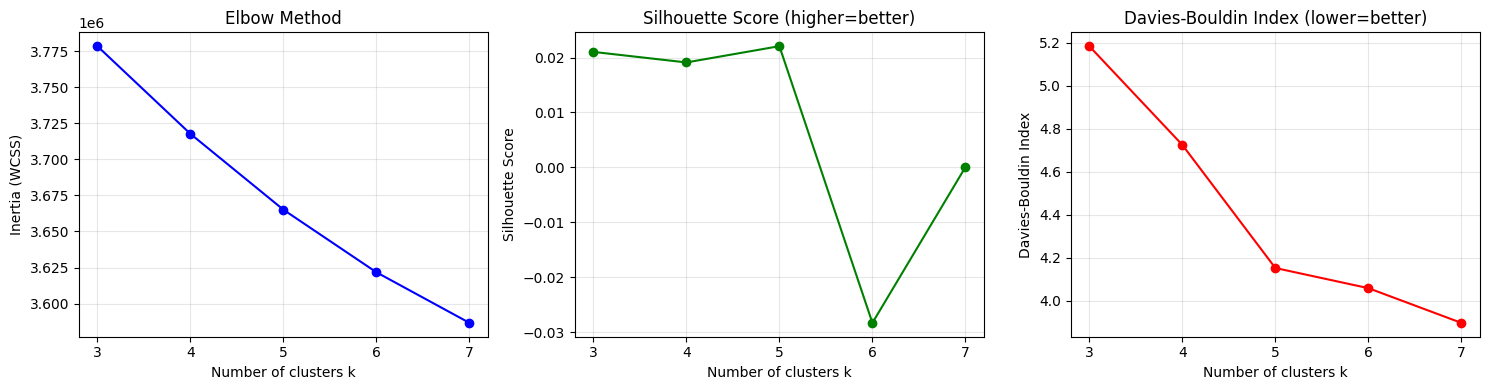


Suggested best k = 5
Metrics at k=5:
   silhouette  davies_bouldin  combined_score
2    0.022071        4.152322        0.900814


In [6]:
# -----------------------------------------------
# MODEL 1: KMEANS with PCA
# -----------------------------------------------

# Sample 30k users
sample_size = 30000
sample_indices = np.random.RandomState(SEED).choice(len(X_pca), sample_size, replace=False)
X_sample = X_pca[sample_indices]

# Test range of k values
k_values = range(3, 8)

inertias = []
silhouettes = []
db_indices = []

from tqdm import tqdm
for k in tqdm(k_values, desc="K-means with PCA"):
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(X_sample)

    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_sample, labels))
    db_indices.append(davies_bouldin_score(X_sample, labels))

# Create evaluation dataframe
kmeans_df = pd.DataFrame({
    'k': list(k_values),
    'inertia': inertias,
    'silhouette': silhouettes,
    'davies_bouldin': db_indices
})

# Add normalized scores for better comparison (0-1 scale)
kmeans_df['sil_norm'] = (kmeans_df['silhouette'] - kmeans_df['silhouette'].min()) / \
                       (kmeans_df['silhouette'].max() - kmeans_df['silhouette'].min())
kmeans_df['db_norm'] = 1 - (kmeans_df['davies_bouldin'] - kmeans_df['davies_bouldin'].min()) / \
                     (kmeans_df['davies_bouldin'].max() - kmeans_df['davies_bouldin'].min())

# Combined score (higher is better)
kmeans_df['combined_score'] = (kmeans_df['sil_norm'] + kmeans_df['db_norm']) / 2
kmeans_df = kmeans_df.sort_values('combined_score', ascending=False)
display(kmeans_df)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Elbow
axes[0].plot(k_values, inertias, marker='o', color='b')
axes[0].set_xlabel('Number of clusters k')
axes[0].set_ylabel('Inertia (WCSS)')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_values) 

# Silhouette (higher is better)
axes[1].plot(k_values, silhouettes, marker='o', color='g')
axes[1].set_xlabel('Number of clusters k')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (higher=better)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_values)

# Davies-Bouldin (lower is better)
axes[2].plot(k_values, db_indices, marker='o', color='r')
axes[2].set_xlabel('Number of clusters k')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index (lower=better)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_values)

plt.tight_layout()
plt.show()

# Select best k based on combined score
best_k = int(kmeans_df.loc[kmeans_df['combined_score'].idxmax(), 'k'])
print(f'\nSuggested best k = {best_k}')
print(f'Metrics at k={best_k}:')
print(kmeans_df[kmeans_df['k'] == best_k][['silhouette', 'davies_bouldin', 'combined_score']])

In [ ]:
# ================================================================
# Why PCA?
# ================================================================
# Problem: 163 features cause "curse of dimensionality"
# - Distance metrics become unreliable in high dimensions
# - All points appear equidistant, resulting in poor cluster separation
# 
# Solution: PCA reduces to 99 components (80% variance)
# - Focuses on directions of maximum variance
# - Removes noise from minor dimensions
# - Improves silhouette from 0.01 → 0.02
#
# Result: Low silhouette score (0.02) indicates weak cluster 
# separation. Customers may form a spectrum of behaviors rather 
# than distinct groups. Analysis proceeds with k=5 and validates 
# through customer segment interpretation.
# ================================================================

In [ ]:
# ================================================================
# Why not DBSCAN?
# ================================================================
# DBSCAN is sensitive to epsilon tuning and struggles with high 
# dimensionality (even after PCA to 99 components). Given the low 
# silhouette scores indicating overlapping behavioral patterns, 
# K-means provides interpretable customer segments suitable for 
# our recommendation system.
# ================================================================

Building hierarchical clustering tree...

Part 1: Dendrogram Visualization (10k subsample)
------------------------------------------------------------


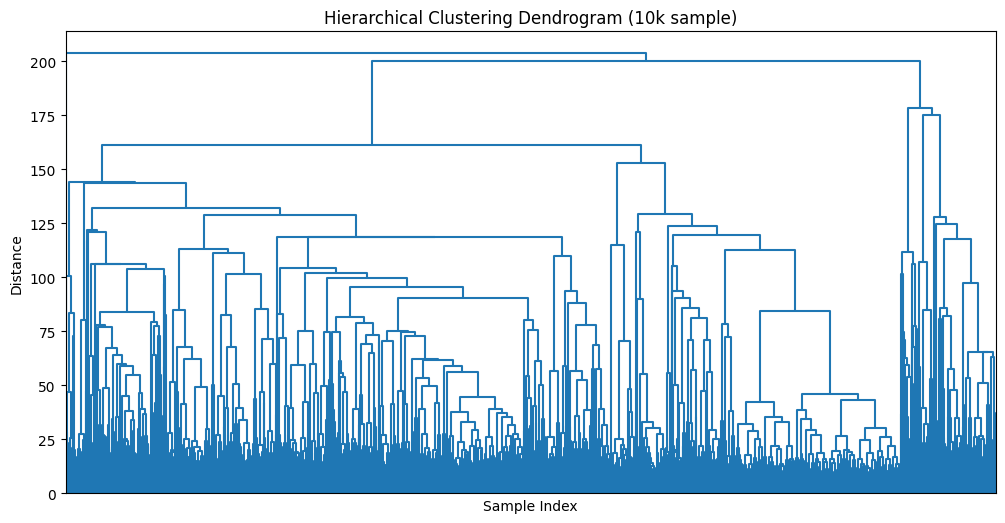

Dendrogram shows gradual merging without clear cluster cutoff
→ Confirms K-means with k=5 is appropriate

Part 2: Quantitative Evaluation (30k sample)
------------------------------------------------------------

Hierarchical Clustering Results (30k sample):


,k,silhouette,davies_bouldin,sil_norm,db_norm,combined_score
2,5,0.025490,4.444365,0.957188,0.729837,0.843512
1,4,0.028221,5.271783,1.000000,0.391739,0.695869
4,7,-0.033987,3.783203,0.024633,1.000000,0.512316
0,3,0.025111,6.230474,0.951238,0.000000,0.475619
3,6,-0.035558,4.182389,0.000000,0.836885,0.418443


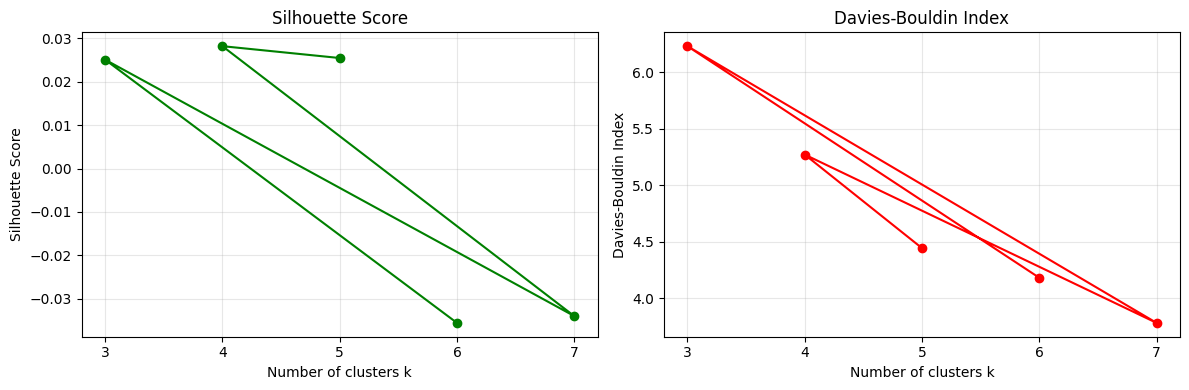

In [ ]:
# -----------------------------------------------
# MODEL 2: Hierarchical Clustering with PCA
# -----------------------------------------------

# Use same 30k sample as K-means for fair comparison
sample_size = 30000  # Match K-means
sample_indices = np.random.RandomState(SEED).choice(len(X_pca), sample_size, replace=False)
X_sample_hc = X_pca[sample_indices]

print("Building hierarchical clustering tree...\n")

# --------------------------------------------------
# Part 1: Dendrogram (10k subsample for visualization)
# --------------------------------------------------
print("Part 1: Dendrogram Visualization (10k subsample)")
print("-" * 60)

# Use smaller subsample just for dendrogram (too messy with 30k)
viz_sample_indices = np.random.RandomState(SEED).choice(len(X_pca), 10000, replace=False)
X_viz = X_pca[viz_sample_indices]

linkage_matrix_viz = linkage(X_viz, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix_viz, no_labels=True, color_threshold=0)
plt.title('Hierarchical Clustering Dendrogram (10k sample)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

print("Dendrogram shows gradual merging without clear cluster cutoff")
print("→ Confirms K-means with k=5 is appropriate\n")

# --------------------------------------------------
# Part 2: Full Evaluation (30k sample for metrics)
# --------------------------------------------------
print("Part 2: Quantitative Evaluation (30k sample)")
print("-" * 60)

# Build linkage on full 30k sample
linkage_matrix = linkage(X_sample_hc, method='ward')

# Test k values matching K-means
k_values = range(3, 8)
hier_results = []

for k in k_values:
    labels = fcluster(linkage_matrix, t=k, criterion='maxclust')
    
    sil = silhouette_score(X_sample_hc, labels)
    db = davies_bouldin_score(X_sample_hc, labels)
    
    hier_results.append({
        'k': k,
        'silhouette': sil,
        'davies_bouldin': db
    })

hier_df = pd.DataFrame(hier_results)

# Add normalized scores
hier_df['sil_norm'] = (hier_df['silhouette'] - hier_df['silhouette'].min()) / \
                       (hier_df['silhouette'].max() - hier_df['silhouette'].min())
hier_df['db_norm'] = 1 - (hier_df['davies_bouldin'] - hier_df['davies_bouldin'].min()) / \
                     (hier_df['davies_bouldin'].max() - hier_df['davies_bouldin'].min())
hier_df['combined_score'] = (hier_df['sil_norm'] + hier_df['db_norm']) / 2

hier_df = hier_df.sort_values('combined_score', ascending=False)

print("\nHierarchical Clustering Results (30k sample):")
display(hier_df)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(hier_df['k'], hier_df['silhouette'], marker='o', color='g')
axes[0].set_xlabel('Number of clusters k')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_values)

axes[1].plot(hier_df['k'], hier_df['davies_bouldin'], marker='o', color='r')
axes[1].set_xlabel('Number of clusters k')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_values)

plt.tight_layout()
plt.show()

## 1.2 - Model Selection

In [ ]:
# ================================================================
# 1.2 - Model Selection
# ================================================================

# --------------------------------------------------
# Comparison with K-means
# --------------------------------------------------
print("\n" + "="*60)
print("Comparison: K-means vs Hierarchical (both on 30k sample)")
print("="*60 + "\n")

# Get Hierarchical best results
best_hier_k = hier_df.iloc[0]['k']
best_hier_sil = hier_df.iloc[0]['silhouette']
best_hier_db = hier_df.iloc[0]['davies_bouldin']

# Get K-means best results
kmeans_at_k = kmeans_df[kmeans_df['k'] == best_k].iloc[0]

comparison = pd.DataFrame({
    'Method': ['K-means', 'Hierarchical'],
    'Best k': [5, int(best_hier_k)],
    'Silhouette': [kmeans_at_k['silhouette'], best_hier_sil],
    'Davies-Bouldin': [kmeans_at_k['davies_bouldin'], best_hier_db]
})

display(comparison)

print("\nConclusion: Both methods show similar performance,")
print("confirming weak cluster separation is a data characteristic,")
print("not a limitation of K-means. We proceed with K-means k=5")
print("for consistency with proposal and computational efficiency.\n")


Comparison: K-means vs Hierarchical (both on 30k sample)



,Method,Best k,Silhouette,Davies-Bouldin
0,K-means,5,0.022071,4.152322
1,Hierarchical,5,0.025490,4.444365



Conclusion: Both methods show similar performance,
confirming weak cluster separation is a data characteristic,
not a limitation of K-means. We proceed with K-means k=5
for consistency with proposal and computational efficiency.



## 1.3 - Final Model Training

In [26]:
# ================================================================
# 1.3 - Final Model Training
# ================================================================

print("\n" + "="*60)
print("1.3 - Final Model Training: K-means with k=5")
print("="*60 + "\n")

# -----------------------------------------------
# Train on FULL dataset (all 175,072 users)
# -----------------------------------------------
print("Training final K-means model on full dataset...")
print(f"  Dataset: {len(X_pca):,} users × {X_pca.shape[1]} PCA components")
print(f"  Algorithm: K-means")
print(f"  Clusters: k={best_k}")
print(f"  Initializations: n_init=10")

# Train final model
final_kmeans = KMeans(n_clusters=best_k, random_state=SEED, n_init=10, max_iter=300)
cluster_labels = final_kmeans.fit_predict(X_pca)

print(f"\n Model training complete")


1.3 - Final Model Training: K-means with k=5

Training final K-means model on full dataset...
  Dataset: 175,072 users × 99 PCA components
  Algorithm: K-means
  Clusters: k=5
  Initializations: n_init=10

 Model training complete


In [27]:
# -----------------------------------------------
# Evaluate final model
# -----------------------------------------------
print("\nFinal Model Performance:")
print("-" * 60)


final_inertia = final_kmeans.inertia_
final_silhouette = silhouette_score(X_pca, cluster_labels)
final_db = davies_bouldin_score(X_pca, cluster_labels)

print(f"\n  Inertia: {final_inertia:,.0f}")
print(f"  Silhouette Score: {final_silhouette:.6f}")
print(f"  Davies-Bouldin Index: {final_db:.6f}\n")


Final Model Performance:
------------------------------------------------------------

  Inertia: 21,299,666
  Silhouette Score: 0.023457
  Davies-Bouldin Index: 4.158377




Cluster Size Distribution:
------------------------------------------------------------


,Cluster,Count,Percentage
0,0,78862,45.05
1,1,23533,13.44
2,2,63000,35.99
3,3,1906,1.09
4,4,7771,4.44


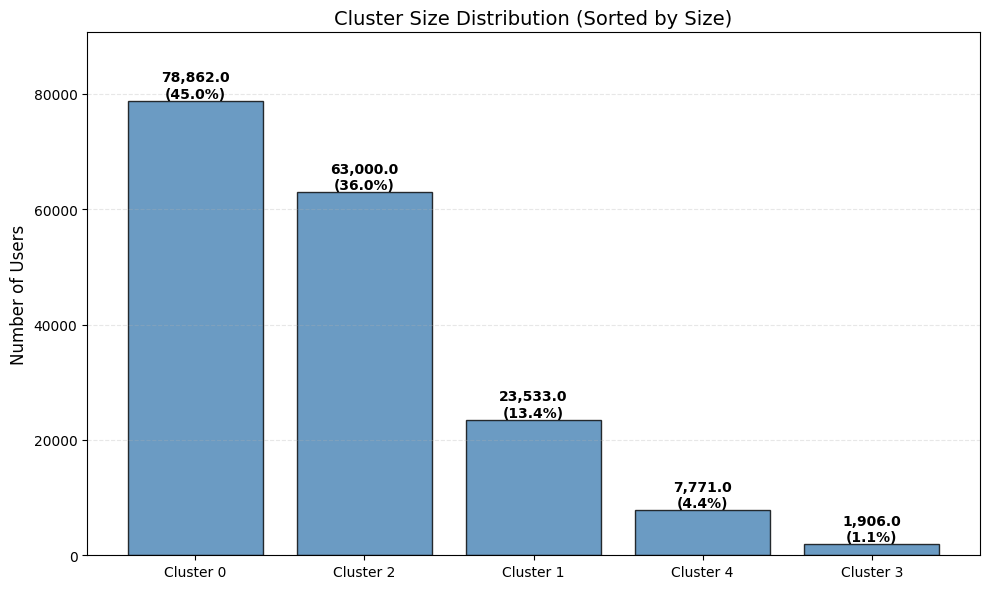

In [35]:
# -----------------------------------------------
# Cluster distribution
# -----------------------------------------------
print("\nCluster Size Distribution:")
print("-" * 60)

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()

cluster_dist = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Count': cluster_counts.values,
    'Percentage': (cluster_counts.values / len(cluster_labels) * 100).round(2)
})

display(cluster_dist)

# Visualize distribution
plt.figure(figsize=(10, 6))

# Sort by count descending
cluster_dist_sorted = cluster_dist.sort_values('Count', ascending=False)

# Create bar chart
bars = plt.bar(range(len(cluster_dist_sorted)), 
               cluster_dist_sorted['Count'], 
               color='steelblue', 
               edgecolor='black',
               alpha=0.8)

# Add cluster labels on x-axis
plt.xticks(range(len(cluster_dist_sorted)), 
           [f"Cluster {i}" for i in cluster_dist_sorted['Cluster']])
plt.ylabel('Number of Users', fontsize=12)
plt.ylim(0, cluster_dist_sorted['Count'].max() * 1.15)
plt.title('Cluster Size Distribution (Sorted by Size)', fontsize=14)

# Add value labels on top of bars
for i, (idx, row) in enumerate(cluster_dist_sorted.iterrows()):
    plt.text(i, row['Count'], 
             f"{row['Count']:,}\n({row['Percentage']:.1f}%)", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add grid for readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
# plt.savefig('cluster_size_distribution.png')
plt.show()

In [36]:
# -----------------------------------------------
# Add cluster labels to user data
# -----------------------------------------------
print("\nAssigning cluster labels to users...")

# Add labels to scaled features
user_features_clustered = user_features_scaled.copy()
user_features_clustered['cluster'] = cluster_labels

# Add labels to raw features (for interpretation)
user_features_raw = pd.read_parquet('../data/processed/user_features_raw.parquet')
user_features_raw['cluster'] = cluster_labels

print(f" Cluster labels assigned to {len(user_features_clustered):,} users")

# Display sample
print("\nSample of clustered users:")
display(user_features_raw[['user_id', 'recency', 'frequency', 'monetary', 
                              'avg_basket_size', 'reorder_ratio', 'preferred_dow',
                                 'preferred_hour', 'avg_order_interval', 'cluster']].head(5))


Assigning cluster labels to users...
 Cluster labels assigned to 175,072 users

Sample of clustered users:


,user_id,recency,frequency,monetary,avg_basket_size,reorder_ratio,preferred_dow,preferred_hour,avg_order_interval,cluster
0,1,0.0,9,50,5.555556,0.700000,1,7,18.250000,1
1,2,30.0,13,179,13.769231,0.463687,1,10,15.416667,1
2,3,17.0,10,77,7.700000,0.571429,0,16,11.888889,0
3,4,21.0,3,13,4.333333,0.076923,4,11,20.000000,2
4,5,10.0,3,25,8.333333,0.240000,3,12,10.500000,0


In [17]:
# -----------------------------------------------
# Save final model and results
# -----------------------------------------------
print("\nSaving final model and cluster assignments...")

import pickle

# Save K-means model
with open('../data/processed/final_kmeans_model.pkl', 'wb') as f:
    pickle.dump(final_kmeans, f)

# Save PCA model (needed for transforming new data)
with open('../data/processed/pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

# Save clustered features
user_features_clustered.to_parquet('../data/processed/user_features_clustered.parquet', index=False)
user_features_raw.to_parquet('../data/processed/user_features_raw_clustered.parquet', index=False)

print(" Saved:")
print("  - final_kmeans_model.pkl")
print("  - pca_model.pkl")
print("  - user_features_clustered.parquet (scaled features + cluster)")
print("  - user_features_raw_clustered.parquet (raw features + cluster)\n")


Saving final model and cluster assignments...
 Saved:
  - final_kmeans_model.pkl
  - pca_model.pkl
  - user_features_clustered.parquet (scaled features + cluster)
  - user_features_raw_clustered.parquet (raw features + cluster)



## 1.4 - Cluster Characterization

In [37]:
# ================================================================
# 1.4 - Cluster Characterization
# ================================================================

print("\n" + "="*60)
print("1.4 - Cluster Characterization")
print("="*60 + "\n")

# Load clustered raw features for interpretation
user_features_raw_clustered = pd.read_parquet('../data/processed/user_features_raw_clustered.parquet')

print(f"Analyzing {len(user_features_raw_clustered):,} users across 5 clusters")
print(f"Features: {user_features_raw_clustered.shape[1] - 2} (excluding user_id and cluster)")

# -----------------------------------------------
# Part 1: Cluster Summary Statistics
# -----------------------------------------------
print("\n" + "-"*60)
print("Part 1: Cluster Summary Statistics")
print("-"*60)

# Key features for characterization
key_features = ['recency', 'frequency', 'monetary', 'avg_basket_size', 
                'reorder_ratio', 'avg_order_interval']

# Calculate mean for each cluster
cluster_summary = user_features_raw_clustered.groupby('cluster')[key_features].mean().round(2)

# Add cluster sizes
cluster_sizes = user_features_raw_clustered['cluster'].value_counts().sort_index()
cluster_summary['cluster_size'] = cluster_sizes
cluster_summary['percentage'] = (cluster_sizes / len(user_features_raw_clustered) * 100).round(2)

print("\nCluster Means (Key Features):")
display(cluster_summary)


1.4 - Cluster Characterization

Analyzing 175,072 users across 5 clusters
Features: 163 (excluding user_id and cluster)

------------------------------------------------------------
Part 1: Cluster Summary Statistics
------------------------------------------------------------

Cluster Means (Key Features):


,recency,frequency,monetary,avg_basket_size,reorder_ratio,avg_order_interval,cluster_size,percentage
cluster,,,,,,,,
0,12.37,21.84,233.35,10.63,0.52,12.27,78862,45.05
1,15.02,15.94,109.61,6.34,0.50,14.59,23533,13.44
2,17.31,10.62,116.03,11.07,0.35,16.37,63000,35.99
3,14.66,13.39,67.83,4.86,0.37,13.54,1906,1.09
4,17.01,11.32,76.37,6.57,0.33,16.71,7771,4.44



------------------------------------------------------------
Part 2: Visual Comparison - Radar Chart
------------------------------------------------------------



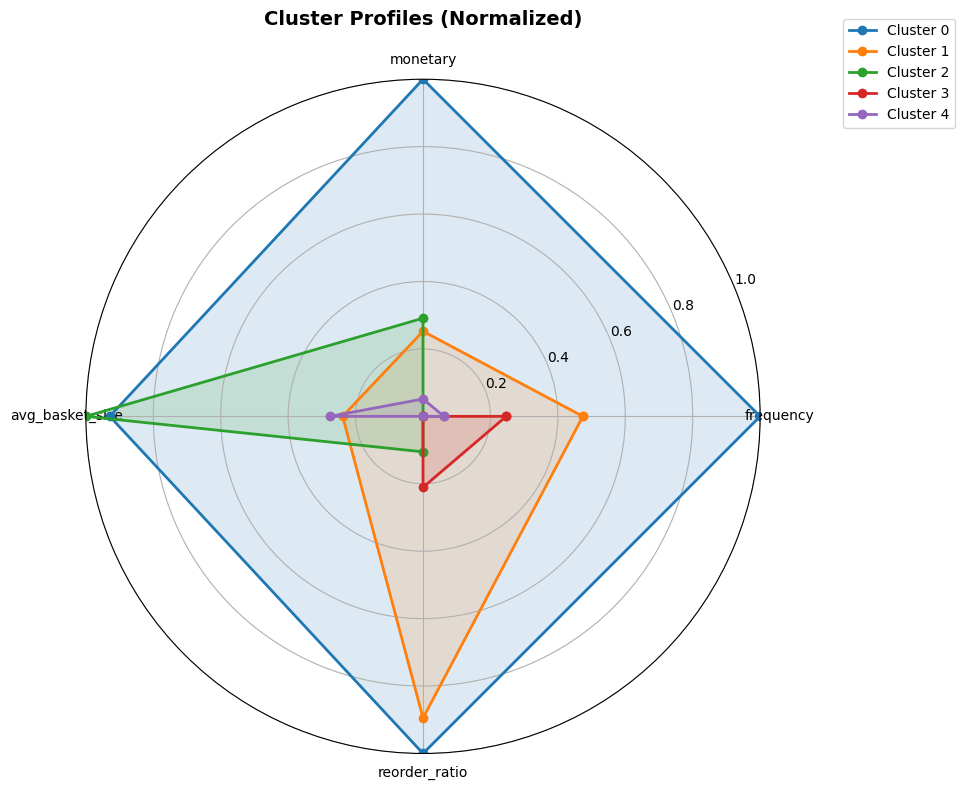

In [40]:
# -----------------------------------------------
# Part 2: Visual Comparison - Radar Chart
# -----------------------------------------------
print("\n" + "-"*60)
print("Part 2: Visual Comparison - Radar Chart")
print("-"*60 + "\n")

# Normalize features to 0-1 scale for radar chart
from sklearn.preprocessing import MinMaxScaler

features_for_radar = ['frequency', 'monetary', 'avg_basket_size', 'reorder_ratio']
scaler_viz = MinMaxScaler()

cluster_means_norm = cluster_summary[features_for_radar].copy()
cluster_means_norm[features_for_radar] = scaler_viz.fit_transform(cluster_means_norm[features_for_radar])

# Create radar chart
fig = plt.figure(figsize=(12, 8))

# Number of variables
categories = features_for_radar
N = len(categories)

# Compute angle for each axis
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialize plot
ax = plt.subplot(111, polar=True)

# Plot each cluster
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for idx, cluster_id in enumerate(range(5)):
    values = cluster_means_norm.loc[cluster_id, features_for_radar].values.tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}', color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

# Fix axis to go in the right order
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Cluster Profiles (Normalized)', size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
# plt.savefig('cluster_profiles.png')
plt.show()


------------------------------------------------------------
Part 3: RFM Analysis by Cluster
------------------------------------------------------------


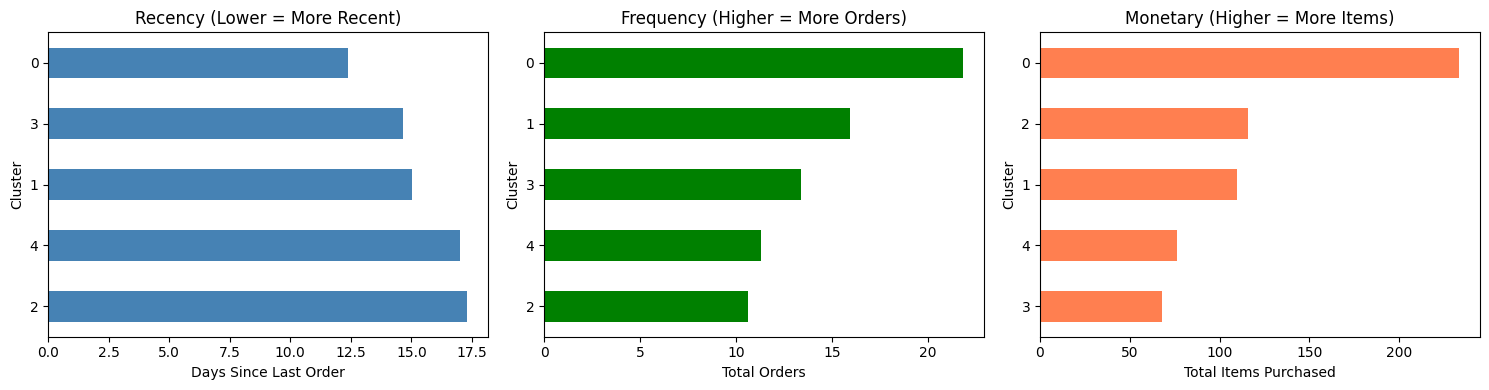


------------------------------------------------------------
Part 4: Behavioral Patterns
------------------------------------------------------------


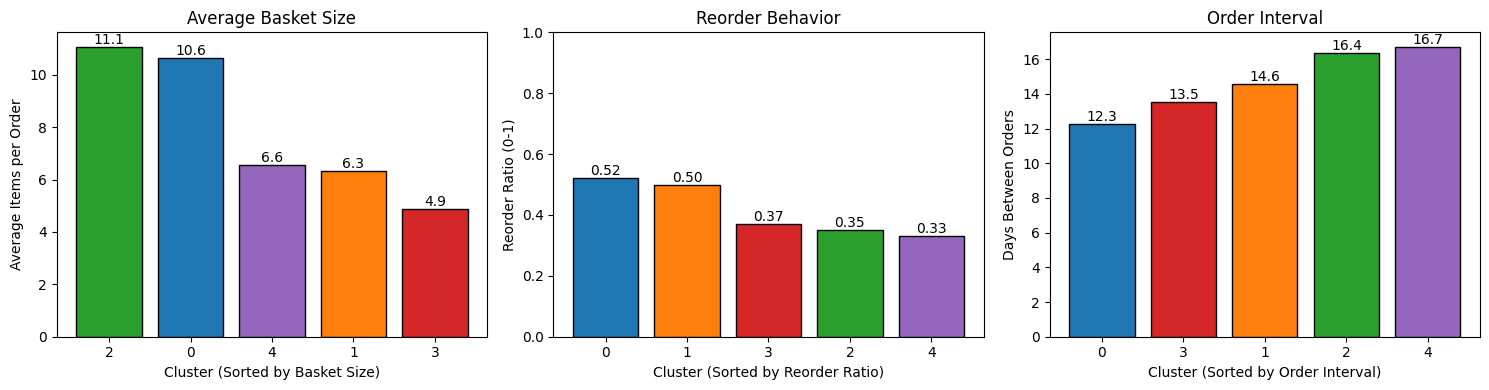


------------------------------------------------------------
Part 5: Temporal Preferences
------------------------------------------------------------

Preferred Shopping Times by Cluster:


,preferred_dow,preferred_hour,preferred_dow_name
cluster,,,
0,0,10,Sun
1,1,9,Mon
2,0,10,Sun
3,1,10,Mon
4,0,10,Sun



------------------------------------------------------------
Part 6: Top Product Categories per Cluster
------------------------------------------------------------

Top 5 Departments by Cluster:

Cluster 0 (78,862 users, 45.0%):
  Produce: 41.6%
  Dairy Eggs: 17.0%
  Beverages: 6.0%
  Snacks: 5.9%
  Frozen: 5.2%

Cluster 1 (23,533 users, 13.4%):
  Beverages: 26.0%
  Snacks: 22.4%
  Produce: 14.1%
  Dairy Eggs: 13.2%
  Frozen: 4.4%

Cluster 2 (63,000 users, 36.0%):
  Produce: 19.1%
  Dairy Eggs: 16.3%
  Frozen: 10.7%
  Pantry: 8.1%
  Snacks: 8.0%

Cluster 3 (1,906 users, 1.1%):
  Alcohol: 43.8%
  Beverages: 11.0%
  Produce: 9.6%
  Snacks: 6.7%
  Dairy Eggs: 6.7%

Cluster 4 (7,771 users, 4.4%):
  Household: 20.6%
  Beverages: 13.0%
  Personal Care: 12.2%
  Dairy Eggs: 9.4%
  Produce: 9.1%



In [45]:
# -----------------------------------------------
# Part 3: RFM Analysis by Cluster
# -----------------------------------------------
print("\n" + "-"*60)
print("Part 3: RFM Analysis by Cluster")
print("-"*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Recency
cluster_summary.sort_values('recency')[['recency']].plot(kind='barh', ax=axes[0], color='steelblue', legend=False)
axes[0].set_xlabel('Days Since Last Order')
axes[0].set_ylabel('Cluster')
axes[0].set_title('Recency (Lower = More Recent)')
axes[0].invert_yaxis()

# Frequency
cluster_summary.sort_values('frequency', ascending=False)[['frequency']].plot(kind='barh', ax=axes[1], color='green', legend=False)
axes[1].set_xlabel('Total Orders')
axes[1].set_ylabel('Cluster')
axes[1].set_title('Frequency (Higher = More Orders)')
axes[1].invert_yaxis()

# Monetary
cluster_summary.sort_values('monetary', ascending=False)[['monetary']].plot(kind='barh', ax=axes[2], color='coral', legend=False)
axes[2].set_xlabel('Total Items Purchased')
axes[2].set_ylabel('Cluster')
axes[2].set_title('Monetary (Higher = More Items)')
axes[2].invert_yaxis()

plt.tight_layout()
# plt.savefig('cluster_RFM_analysis.png')
plt.show()

# -----------------------------------------------
# Part 4: Behavioral Patterns
# -----------------------------------------------
print("\n" + "-"*60)
print("Part 4: Behavioral Patterns")
print("-"*60)

# Define consistent cluster colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


# Plot 1: Average Basket Size (DESCENDING)
# -----------------------------------------------
basket_sorted = cluster_summary['avg_basket_size'].sort_values(ascending=False)
basket_colors = [colors[idx] for idx in basket_sorted.index]

axes[0].bar(range(5), basket_sorted.values, color=basket_colors, edgecolor='black')
axes[0].set_xlabel('Cluster (Sorted by Basket Size)')
axes[0].set_ylabel('Average Items per Order')
axes[0].set_title('Average Basket Size')
axes[0].set_xticks(range(5))
axes[0].set_xticklabels([f'{idx}' for idx in basket_sorted.index])
for i, (idx, v) in enumerate(basket_sorted.items()):
    axes[0].text(i, v, f'{v:.1f}', ha='center', va='bottom')


# Plot 2: Reorder Ratio (DESCENDING)
# -----------------------------------------------
reorder_sorted = cluster_summary['reorder_ratio'].sort_values(ascending=False)
reorder_colors = [colors[idx] for idx in reorder_sorted.index]

axes[1].bar(range(5), reorder_sorted.values, color=reorder_colors, edgecolor='black')
axes[1].set_xlabel('Cluster (Sorted by Reorder Ratio)')
axes[1].set_ylabel('Reorder Ratio (0-1)')
axes[1].set_title('Reorder Behavior')
axes[1].set_xticks(range(5))
axes[1].set_xticklabels([f'{idx}' for idx in reorder_sorted.index])
axes[1].set_ylim(0, 1)
for i, (idx, v) in enumerate(reorder_sorted.items()):
    axes[1].text(i, v, f'{v:.2f}', ha='center', va='bottom')


# Plot 3: Order Interval (ASCENDING - shorter is better)
# -----------------------------------------------
interval_sorted = cluster_summary['avg_order_interval'].sort_values(ascending=True)
interval_colors = [colors[idx] for idx in interval_sorted.index]

axes[2].bar(range(5), interval_sorted.values, color=interval_colors, edgecolor='black')
axes[2].set_xlabel('Cluster (Sorted by Order Interval)')
axes[2].set_ylabel('Days Between Orders')
axes[2].set_title('Order Interval')
axes[2].set_xticks(range(5))
axes[2].set_xticklabels([f'{idx}' for idx in interval_sorted.index])
for i, (idx, v) in enumerate(interval_sorted.items()):
    axes[2].text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
# plt.savefig('cluster_behavioral_patterns.png')
plt.show()

# -----------------------------------------------
# Part 5: Temporal Preferences
# -----------------------------------------------
print("\n" + "-"*60)
print("Part 5: Temporal Preferences")
print("-"*60)

# Most common day of week per cluster
temporal_features = ['preferred_dow', 'preferred_hour']
temporal_summary = user_features_raw_clustered.groupby('cluster')[temporal_features].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
)

day_names = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
temporal_summary['preferred_dow_name'] = temporal_summary['preferred_dow'].map(day_names)

print("\nPreferred Shopping Times by Cluster:")
display(temporal_summary)

# -----------------------------------------------
# Part 6: Top Product Categories per Cluster
# -----------------------------------------------
print("\n" + "-"*60)
print("Part 6: Top Product Categories per Cluster")
print("-"*60)

# Get department columns
dept_cols = [col for col in user_features_raw_clustered.columns if col.startswith('dept_')]

print("\nTop 5 Departments by Cluster:\n")

for cluster_id in range(5):
    cluster_data = user_features_raw_clustered[user_features_raw_clustered['cluster'] == cluster_id]
    
    # Average percentage across users in cluster
    dept_means = cluster_data[dept_cols].mean()
    top_5_depts = dept_means.nlargest(5)
    
    print(f"Cluster {cluster_id} ({cluster_sizes[cluster_id]:,} users, {cluster_sizes[cluster_id]/len(user_features_raw_clustered)*100:.1f}%):")
    for dept, pct in top_5_depts.items():
        dept_name = dept.replace('dept_', '').replace('_', ' ').title()
        print(f"  {dept_name}: {pct*100:.1f}%")
    print()

In [46]:
# -----------------------------------------------
# Part 7: Segment Names & Business Interpretation
# -----------------------------------------------

segment_names = {
    0: "Power Users",
    1: "Routine Snackers", 
    2: "Bulk Shoppers",
    3: "Alcohol Enthusiasts",
    4: "Household Essentials"
}

segment_descriptions = {
    0: """
    **Power Users** (45.0% - 78,862 users)
    - Highest frequency (21.8 orders) and spending (233 items)
    - Large baskets (10.6 items), high loyalty (0.52 reorder ratio)
    - Weekly shoppers (12.3 day interval)
    - Fresh food focused: Produce (41.6%), Dairy Eggs (17.0%)
    - Shop Sundays at 10am
    → Most valuable segment, loyal routine shoppers
    """,
    
    1: """
    **Routine Snackers** (13.4% - 23,533 users)
    - Regular frequency (15.9 orders), smaller baskets (6.3 items)
    - High loyalty (0.50 reorder ratio)
    - Bi-weekly shoppers (14.6 day interval)
    - Beverages (26.0%), Snacks (22.4%) focused
    - Shop Mondays at 9am (workweek prep?)
    → Consistent snack/beverage buyers, potential subscription candidates
    """,
    
    2: """
    **Bulk Shoppers** (36.0% - 63,000 users)
    - Low frequency (10.6 orders) but largest baskets (11.1 items)
    - Low loyalty (0.35 reorder ratio) - explorers/variety seekers
    - Infrequent (16.4 day interval)
    - Diverse: Produce (19.1%), Dairy (16.3%), Frozen (10.7%)
    - Shop Sundays at 10am
    → Stock-up shoppers, need targeted promotions to drive frequency
    """,
    
    3: """
    **Alcohol Enthusiasts** (1.1% - 1,906 users) NICHE
    - Medium frequency (13.4 orders), smallest baskets (4.9 items)
    - Low loyalty (0.37 reorder ratio) - targeted purchases
    - ALCOHOL dominates (43.8%), Beverages (11.0%)
    - Shop Mondays at 10am
    → Highly specialized segment, alcohol-focused purchases
    → Could merge with Cluster 1 if not actionable standalone
    """,
    
    4: """
    **Household Essentials** (4.4% - 7,771 users)
    - Low frequency (11.3 orders), small baskets (6.6 items)
    - Lowest loyalty (0.33 reorder ratio) - occasional needs-based
    - Infrequent (16.7 day interval)
    - Household (20.6%), Personal Care (12.2%), Beverages (13.0%)
    - Shop Sundays at 10am
    → Utilitarian shoppers, buy when needed, price-sensitive potential
    """
}

print("\n" + "="*70)
print("FINAL SEGMENT NAMES & INTERPRETATIONS")
print("="*70 + "\n")

for cluster_id in range(5):
    print(f"{'='*70}")
    print(f"CLUSTER {cluster_id}: {segment_names[cluster_id].upper()}")
    print(f"{'='*70}")
    print(segment_descriptions[cluster_id])
    print()


FINAL SEGMENT NAMES & INTERPRETATIONS

CLUSTER 0: POWER USERS

    **Power Users** (45.0% - 78,862 users)
    - Highest frequency (21.8 orders) and spending (233 items)
    - Large baskets (10.6 items), high loyalty (0.52 reorder ratio)
    - Weekly shoppers (12.3 day interval)
    - Fresh food focused: Produce (41.6%), Dairy Eggs (17.0%)
    - Shop Sundays at 10am
    → Most valuable segment, loyal routine shoppers
    

CLUSTER 1: ROUTINE SNACKERS

    **Routine Snackers** (13.4% - 23,533 users)
    - Regular frequency (15.9 orders), smaller baskets (6.3 items)
    - High loyalty (0.50 reorder ratio)
    - Bi-weekly shoppers (14.6 day interval)
    - Beverages (26.0%), Snacks (22.4%) focused
    - Shop Mondays at 9am (workweek prep?)
    → Consistent snack/beverage buyers, potential subscription candidates
    

CLUSTER 2: BULK SHOPPERS

    **Bulk Shoppers** (36.0% - 63,000 users)
    - Low frequency (10.6 orders) but largest baskets (11.1 items)
    - Low loyalty (0.35 reorder rat

In [47]:
# -----------------------------------------------
# Business Recommendations by Segment
# -----------------------------------------------
print("\n" + "="*70)
print("ACTIONABLE BUSINESS STRATEGIES")
print("="*70 + "\n")

recommendations = {
    0: """
    **Power Users** - RETAIN & REWARD
    - Launch VIP loyalty program with exclusive benefits
    - Prioritize inventory for their favorite categories (produce, dairy)
    - Offer free delivery to maintain frequency
    - Test premium/organic product lines
    """,
    
    1: """
    **Routine Snackers** - SUBSCRIPTION OPPORTUNITY
    - Launch snack/beverage subscription boxes
    - Personalized recommendations for new snacks
    - Bundle deals on beverages
    - Target Monday morning campaigns
    """,
    
    2: """
    **Bulk Shoppers** - INCREASE FREQUENCY
    - Large order discounts to encourage stock-ups
    - "Weekly essentials" reminders to shorten intervals
    - Highlight variety/new products to satisfy exploration
    - Combo deals across categories
    """,
    
    3: """
    **Alcohol Enthusiasts** - NICHE TARGETING
    - Curated alcohol recommendations
    - Pairing suggestions (alcohol + snacks)
    - Exclusive alcohol promotions
    - Consider: Small segment, may merge with Routine Snackers if needed
    """,
    
    4: """
    **Household Essentials** - VALUE MESSAGING
    - Emphasize competitive pricing on household items
    - Bundle deals (buy household + get produce discount)
    - Reminder campaigns when stock likely low
    - Cross-sell opportunities to increase basket size
    """
}

for cluster_id in range(5):
    print(f"{segment_names[cluster_id].upper()}:")
    print(recommendations[cluster_id])
    print()


ACTIONABLE BUSINESS STRATEGIES

POWER USERS:

    **Power Users** - RETAIN & REWARD
    - Launch VIP loyalty program with exclusive benefits
    - Prioritize inventory for their favorite categories (produce, dairy)
    - Offer free delivery to maintain frequency
    - Test premium/organic product lines
    

ROUTINE SNACKERS:

    **Routine Snackers** - SUBSCRIPTION OPPORTUNITY
    - Launch snack/beverage subscription boxes
    - Personalized recommendations for new snacks
    - Bundle deals on beverages
    - Target Monday morning campaigns
    

BULK SHOPPERS:

    **Bulk Shoppers** - INCREASE FREQUENCY
    - Large order discounts to encourage stock-ups
    - "Weekly essentials" reminders to shorten intervals
    - Highlight variety/new products to satisfy exploration
    - Combo deals across categories
    

ALCOHOL ENTHUSIASTS:

    **Alcohol Enthusiasts** - NICHE TARGETING
    - Curated alcohol recommendations
    - Pairing suggestions (alcohol + snacks)
    - Exclusive alcohol p

In [48]:
# -----------------------------------------------
# Save segment mapping
# -----------------------------------------------
print("\n" + "-"*70)
print("Saving segment names...")

segment_mapping = pd.DataFrame({
    'cluster': list(segment_names.keys()),
    'segment_name': list(segment_names.values()),
    'size': [cluster_sizes[i] for i in range(5)],
    'percentage': [(cluster_sizes[i]/len(user_features_raw_clustered)*100).round(2) for i in range(5)]
})

display(segment_mapping)

# Add segment names to clustered data
user_features_clustered['segment_name'] = user_features_clustered['cluster'].map(segment_names)
user_features_raw_clustered['segment_name'] = user_features_raw_clustered['cluster'].map(segment_names)

# Save
user_features_clustered.to_parquet('../data/processed/user_features_clustered.parquet', index=False)
user_features_raw_clustered.to_parquet('../data/processed/user_features_raw_clustered.parquet', index=False)

print("\n Segment names added and saved")

print("\n" + "="*70)
print("PHASE 1 COMPLETE - CUSTOMER SEGMENTATION")
print("="*70)
print(f"""
Summary:
- 5 customer segments identified via K-means clustering
- 175,072 users analyzed across 163 features (reduced to 99 via PCA)
- Segments range from Power Users (45%) to niche Alcohol Enthusiasts (1.1%)
- Clear behavioral patterns and actionable business strategies defined

Next Phase: Build recommendation systems tailored to each segment
""")


----------------------------------------------------------------------
Saving segment names...


,cluster,segment_name,size,percentage
0,0,Power Users,78862,45.05
1,1,Routine Snackers,23533,13.44
2,2,Bulk Shoppers,63000,35.99
3,3,Alcohol Enthusiasts,1906,1.09
4,4,Household Essentials,7771,4.44



 Segment names added and saved

PHASE 1 COMPLETE - CUSTOMER SEGMENTATION

Summary:
- 5 customer segments identified via K-means clustering
- 175,072 users analyzed across 163 features (reduced to 99 via PCA)
- Segments range from Power Users (45%) to niche Alcohol Enthusiasts (1.1%)
- Clear behavioral patterns and actionable business strategies defined

Next Phase: Build recommendation systems tailored to each segment

